In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import onnxruntime as rt
import onnx
from skl2onnx.common.data_types import FloatTensorType
from skl2onnx import to_onnx
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier
from skl2onnx import convert_sklearn

### Visualise some features to decide how to split them or morph them

In [30]:
# Commented out because this just visualises desired fields
if False: 
  plt.clf()
  apps = [col for col in data.columns if 'appointment' in col and 'number' not in col and 'combined' not in col]
  # Combine Appointment values in a new feature
  data["appointment_combined"] = data[apps].sum(axis=1)
  data.boxplot(column=['appointment_combined'])
  plt.show()
  data.drop(columns='appointment_combined', inplace=True)

  # Address Exploration

  plt.clf()
  adds = [col for col in data.columns if 'address' in col]
  for row in details.itertuples():
      if row[3] in adds:
          print(f"{row[3]} :::: {row[6]}")
  data.hist(column=adds, figsize=(25, 15))
  plt.show()

  plt.clf()
  contacts = [col for col in data.columns if 'contacts' in col]
  for row in details.itertuples():
      if row[3] in contacts:
          print(f"{row[3]} :::: {row[6]}")
  data.hist(column=contacts, figsize=(25, 15))
  plt.show()

  plt.clf()
  obstacles = [col for col in data.columns if 'obstacle' in col]
  for row in details.itertuples():
      if row[3] in obstacles:
          print(f"{row[3]} :::: {row[6]}")
  data.hist(column=obstacles, figsize=(25, 15))
  plt.show()

  plt.clf()
  avail = [col for col in data.columns if 'availability' in col]
  for row in details.itertuples():
      if row[3] in avail:
          print(f"{row[3]} :::: {row[6]}")
  data.hist(column=avail, figsize=(25, 15))
  plt.show()

### Set up the Metamorphic and EP relationships to be tested

In [35]:
# Define metamorphic transformations
def perturbation(df, cols):
    df_perturbed = df.copy()
    for col in cols:
        df_perturbed[col] = df[col] + np.random.normal(0, df[col].std(), size=df[col].shape)
    return df_perturbed

def permutation(df, cols):
    df_permuted = df.copy()
    for col in cols:
        df_permuted[col] = np.random.permutation(df[col])   
    return df_permuted

In [36]:

# Set up metamorphic relationships
metamorphic_relations=[
    {'name': 'appointments', 'target': lambda df: [col for col in df.columns if 'appointment' in col],
      'transformations': [{'name': 'permutation', 'function': permutation}, {'name': 'perturbation', 'function': perturbation}]},
    {'name': 'address_numerical', 'target': lambda df: [col for col in df.columns if 'address_number' in col or 'address_days' in col],
      'transformations': [{'name': 'permutation', 'function': permutation}, {'name': 'perturbation', 'function': perturbation}]},
    {'name': 'address_binary', 'target': lambda df: [col for col in df.columns if 'address_latest' in col or 'address_unique' in col],
      'transformations': [{'name': 'permutation', 'function': permutation}]},
]


In [ ]:
# DeSet up equivalent partitions
partition_tests = [
    {
    # Related to obstacles
    'name': 'financial',
    'partitions': [ 
        {"name": "fin_0", "condition": lambda df: df['obstacle_financial_problems'] < 0.5},
        {"name": "fin_1", "condition": lambda df: df['obstacle_financial_problems'] > 0.5}
    ]
    },{
    'name': 'psychological',
    'partitions': [
        {"name": "psyc_0", "condition": lambda df: df['obstacle_hist_psychological_problems'] < 0.5 and df['obstacle_psychological_problems'] < 0.5},
        {"name": "psyc_1", "condition": lambda df: df['obstacle_hist_psychological_problems'] > 0.5 and df['obstacle_psychological_problems'] > 0.5}
    ]
    },{
    'name': 'language',
    'partitions': [
        {"name": "lan_0", "condition": lambda df: df['obstacle_hist_language'] < 0.5},
        {"name": "lan_1", "condition": lambda df: df['obstacle_hist_language'] > 0.5}
    ]
    },{
    'name': 'addiction',
    'partitions': [
        {"name": "addict_0", "condition": lambda df: df['obstacle_hist_addiction_problems'] < 0.5},
        {"name": "addict_1", "condition": lambda df: df['obstacle_hist_addiction_problems'] > 0.5}
    ]
    },
    # Related to availability deviations
    {
    'name': 'social',
    'partitions': [
        {"name": "social_0", "condition": lambda df: df['availability_recent_deviating_due_to_social_social_situation'] < 0.5},
        {"name": "social_1", "condition": lambda df: df['availability_recent_deviating_due_to_social_social_situation'] > 0.5}
    ]
    },{
    'name': 'medical',
    'partitions': [
        {"name": "medical_0", "condition": lambda df: df['availability_recent_deviating_due_to_medical_circumstances'] < 0.5},
        {"name": "medical_1", "condition": lambda df: df['availability_recent_deviating_due_to_medical_circumstances'] > 0.5}
    ]
    },

    
]

In [96]:
# Apply metamorphic testing
def metamorphic_test(model, X_test, y_test, runs=5):
    for metamorphic in metamorphic_relations:
        target_columns = metamorphic['target'](X_test)
        print(f"Test: {metamorphic["name"]}")

        for transformation in metamorphic['transformations']:
            
            print(f"{transformation['name']} test")
            acc_list = []
            for run in range(runs):
    
                data_sample = X_test.sample(n=500)

                tranf_data = transformation['function'](data_sample, target_columns)
                tranf_labels = y_test.loc[tranf_data.index]

                predictions = model.predict(data_sample)
                accuracy = accuracy_score(tranf_labels, predictions)

                if not tranf_data.empty:
                # Predictions using the model
                    meta_predictions = model.predict(tranf_data)

                    # Calculate accuracy for this partition
                    meta_accuracy = accuracy_score(tranf_labels, meta_predictions)
                    acc_list.append(abs(meta_accuracy - accuracy))

            print(f"Average accuracy difference: {np.mean(acc_list)}")
            #print(f"Deviation in accuracy: {np.std(acc_list)}")
            print()

In [66]:
# Apply equivalent partitioning
# Needs some work with multiple train/test splits
def equivalence_partitioning_test(model, X_test, y_test, runs=5):
    for test in partition_tests:
        for partition in test:

            print(f'Partition on : {partition['name']}')

            for part in partition['partitions']:

                print(f'Partition: {part['name']}')
                acc_list = []
                for run in range(runs):
                    
                    data_sample = X_test.sample(n=500)

                    partition_data = data_sample[part["condition"](data_sample)]
                    partition_labels = y_test.loc[partition_data.index]  # Get the actual labels for the partition

                    if not partition_data.empty:
                        # Predictions using the model
                        predictions = model.predict(partition_data)

                        # Calculate accuracy for this partition
                        accuracy = accuracy_score(partition_labels, predictions)
                        acc_list.append(accuracy)

                print(f"Average accuracy: {np.mean(acc_list)}")
                print(f"Deviation in accuracy: {np.std(acc_list)}")
                print()

In [55]:
from sklearn.metrics import classification_report, confusion_matrix

# Classic ML performance
def ML_evaluation(model, X_test, y_test, runs=5):

    print("Classic ML Evaluation")
    acc_list = []
    reports = []
    confusion_matrices = []
    for run in range(runs):
        
        data_sample = X_test.sample(n=500)

        partition_labels = y_test.loc[data_sample.index] 

        if not data_sample.empty:
            # Predictions using the model
            predictions = model.predict(data_sample)

            # Calculate accuracy for this partition
            accuracy = accuracy_score(partition_labels, predictions)
            acc_list.append(accuracy)
            reports.append(classification_report(partition_labels, predictions, output_dict=True))
            confusion_matrices.append(confusion_matrix(partition_labels, predictions))

    print("Final Results")
    print(f"Average accuracy: {np.mean(acc_list)}")

    weighted_precision = [r['weighted avg']['precision'] for r in reports]
    weighted_recall = [r['weighted avg']['recall'] for r in reports]

    print("Average Weighted Precision:", np.mean(weighted_precision))
    print("Average Weighted Recall:", np.mean(weighted_recall))
    
    stacked = np.stack(confusion_matrices, axis=0)
    print(f"Average confusion:\n {np.mean(stacked, axis=0)}")

### Now we set up the good and bad models

We will use an AdaBoost model for both, since we believe the major problem is using features that are either badly recorded or shouldn't be relevant to the predicition of fraud risk.

In [52]:
# Let's load the dataset
data = pd.read_csv('data/investigation_train_large_checked.csv')
details = pd.read_csv('data/data_description.csv', encoding='latin1')

# Rename columns to english for ease of use
data.rename(columns=dict(zip(details['Feature (nl)'], details['Feature (en)'])), inplace=True)
data.drop(columns=["Ja", "Nee"], inplace=True)
data.fillna(data.mean(), inplace=True)

# Let's specify the features and the target
y = data['checked'].astype(int)
X = data.drop(['checked'], axis=1)
X = X.astype(np.float32)

In [42]:
# Set up the Column selector for the good model
from sklearn.base import BaseEstimator, TransformerMixin

class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.columns]

In [50]:
# Let's split the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

y_test = y_test.to_frame()

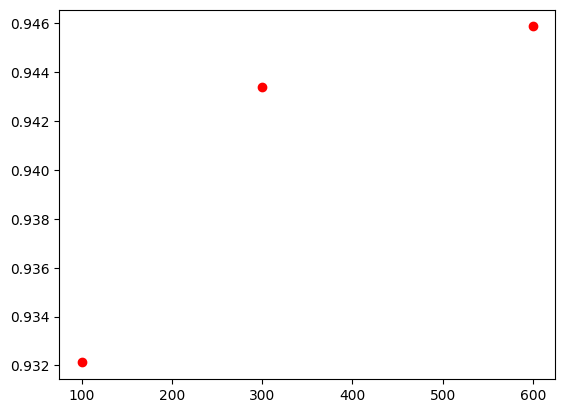

In [47]:
# Find best estimator hyperparameter
plt.clf()
for estimators in [100, 300, 600]:
    clf = AdaBoostClassifier(n_estimators=estimators, random_state=42)

    clf.fit(X_train, y_train) 

    y_pred = clf.predict(X_test)

    plt.plot(estimators, accuracy_score(y_test, y_pred), label='Line', color='blue')   
    plt.scatter(estimators, accuracy_score(y_test, y_pred), color='red', label='Points')

plt.show()

### For the sake of performance, we will select 100 as our estimator number, since the accuracy barely increases after this point

In [88]:
# Set up the models

# Remove useless features if there are any 
selector = VarianceThreshold()

good_columns = [col for col in X_train.columns if 'address' not in col and 'appointment' not in col]

bad_model = Pipeline(steps=[('classification', AdaBoostClassifier(n_estimators=100, random_state=42))])
good_model = Pipeline(steps=[('column filter', ColumnSelector(good_columns)), 
                             ('classification', AdaBoostClassifier(n_estimators=100, random_state=42))])

In [ ]:
# Train the bad model
bad_model.fit(X_train, y_train)


In [97]:
# Evaluate the bad model

#ML_evaluation(bad_model, X_test, y_test)
metamorphic_test(bad_model, X_test, y_test)
#equivalence_partitioning_test(bad_model, X_test, y_test)

Test: appointments
permutation test
Average accuracy difference: 0.013999999999999967

perturbation test
Average accuracy difference: 0.0067999999999999615

Test: address_numerical
permutation test
Average accuracy difference: 0.003999999999999959

perturbation test
Average accuracy difference: 0.001200000000000001

Test: address_binary
permutation test
Average accuracy difference: 0.0



In [ ]:
# Train the good model
good_model.fit(X_train, y_train)

In [98]:
# Evaluate the good model

#ML_evaluation(bad_model, X_test, y_test)
metamorphic_test(good_model, X_test, y_test)
#equivalence_partitioning_test(bad_model, X_test, y_test)

Test: appointments
permutation test
Average accuracy difference: 0.0

perturbation test
Average accuracy difference: 0.0

Test: address_numerical
permutation test
Average accuracy difference: 0.0

perturbation test
Average accuracy difference: 0.0

Test: address_binary
permutation test
Average accuracy difference: 0.0



In [ ]:
# Let's convert the model to ONNX
onnx_model = convert_sklearn(
    pipeline, initial_types=[('X', FloatTensorType((None, X.shape[1])))],
    target_opset=12)

# Let's check the accuracy of the converted model
sess = rt.InferenceSession(onnx_model.SerializeToString())
y_pred_onnx =  sess.run(None, {'X': X_test.values.astype(np.float32)})

accuracy_onnx_model = accuracy_score(y_test, y_pred_onnx[0])
print('Accuracy of the ONNX model: ', accuracy_onnx_model)

In [ ]:
# Let's save the model
onnx.save(onnx_model, "model/gboost.onnx")

# Let's load the model
new_session = rt.InferenceSession("model/gboost.onnx")

# Let's predict the target
y_pred_onnx2 =  new_session.run(None, {'X': X_test.values.astype(np.float32)})

accuracy_onnx_model = accuracy_score(y_test, y_pred_onnx2[0])
print('Accuracy of the ONNX model: ', accuracy_onnx_model)
